In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]


def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

864538487/864538487 [==============================] - 18s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736557430/5736557430 [==============================] - 73s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528640507/5528640507 [==============================] - 71s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [2]:
# preparing data
# generate CSV metadata file to read img paths and labels from it
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# generate CSV files for all data portions, labeling nevus and seborrheic keratosis
# as 0 (benign), and melanoma as 1 (malignant)
# you should replace "data" path to your extracted dataset path
# don't replace if you used download_and_extract_dataset() function
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [3]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [4]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [5]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

In [6]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds


valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

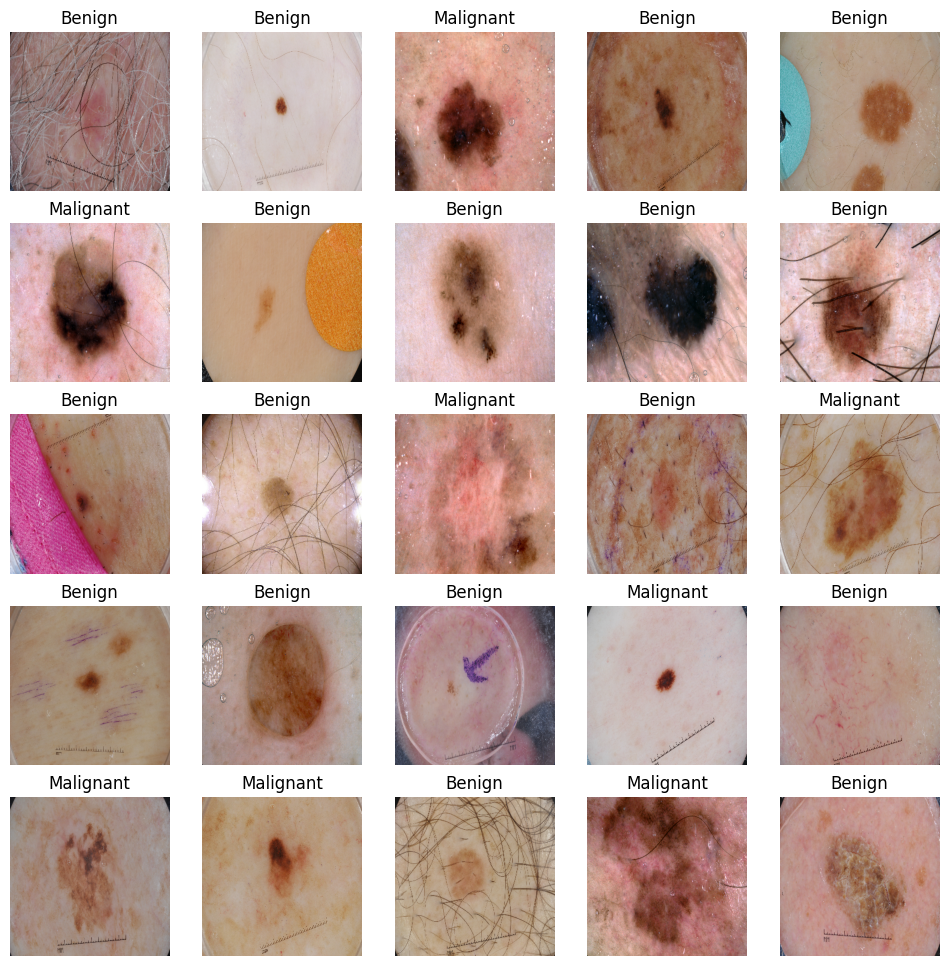

In [7]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')

show_batch(batch)

In [8]:
# building the model
# InceptionV3 model & pre-trained weights
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [9]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds,
                steps_per_epoch=n_training_samples // batch_size,
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=100,
                callbacks=[tensorboard, modelcheckpoint])

Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8014
Epoch 1: val_loss improved from inf to 0.50873, saving model to benign-vs-malignant_64_rmsprop_0.509.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 230s 4s/step - loss: 0.4090 - accuracy: 0.8014 - val_loss: 0.5087 - val_accuracy: 0.8047
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8201
Epoch 2: val_loss improved from 0.50873 to 0.47483, saving model to benign-vs-malignant_64_rmsprop_0.475.h5
31/31 [==============================] - 13s 436ms/step - loss: 0.3909 - accuracy: 0.8201 - val_loss: 0.4748 - val_accuracy: 0.7969
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8286
Epoch 3: val_loss improved from 0.47483 to 0.43331, saving model to benign-vs-malignant_64_rmsprop_0.433.h5
31/31 [==============================] - 12s 393ms/step - loss: 0.3758 - accuracy: 0.8286 - val_loss: 0.4333 - val_accuracy: 0.8125
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8362
Epoch 4: val_loss did not improve from 0.43331
31/31 [==============================] - 9s 299ms/step - l

In [10]:
# evaluation

# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  return ds


test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [11]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [ ]:
# load the weights with the least loss
m.load_weights("benign-vs-malignant_64_rmsprop_0.399.h5")

In [ ]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...


In [ ]:
from sklearn.metrics import accuracy_score

def get_predictions(threshold=None):
  """
  Returns predictions for binary classification given `threshold`
  For instance, if threshold is 0.3, then it'll output 1 (malignant) for that sample if
  the probability of 1 is 30% or more (instead of 50%)
  """
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test melanoma probability
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, it's 0 (benign)
  return result

threshold = 0.23
# get predictions with 23% threshold
# which means if the model is 23% sure or more that is malignant,
# it's assigned as malignant, otherwise it's benign
y_pred = get_predictions(threshold)
accuracy_after = accuracy_score(y_test, y_pred)
print("Accuracy after setting the threshold:", accuracy_after)

19/19 [==============================] - 2s 123ms/step
Accuracy after setting the threshold: 0.7883333333333333


[[0.5610766  0.4389234 ]
 [0.23931624 0.76068376]]


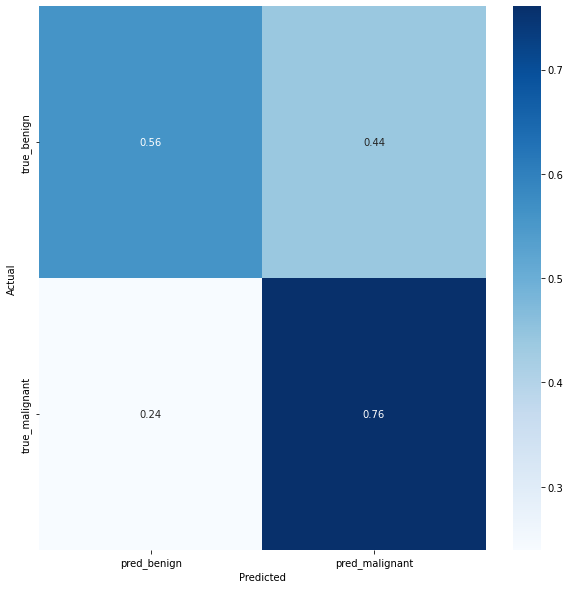

ROC AUC: 0.661


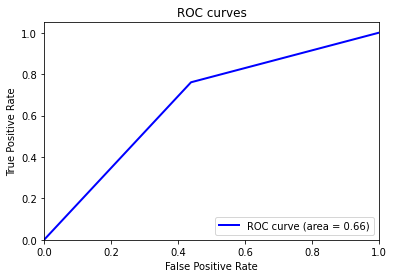

Melanoma Sensitivity: 0.7606837606837606
Melanoma Specificity: 0.5610766045548654


In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f',
              xticklabels=[f"pred_{c}" for c in class_names],
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  # plot the resulting confusion matrix
  plt.show()


def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix(y_test, y_pred)
plot_roc_auc(y_test, y_pred)
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

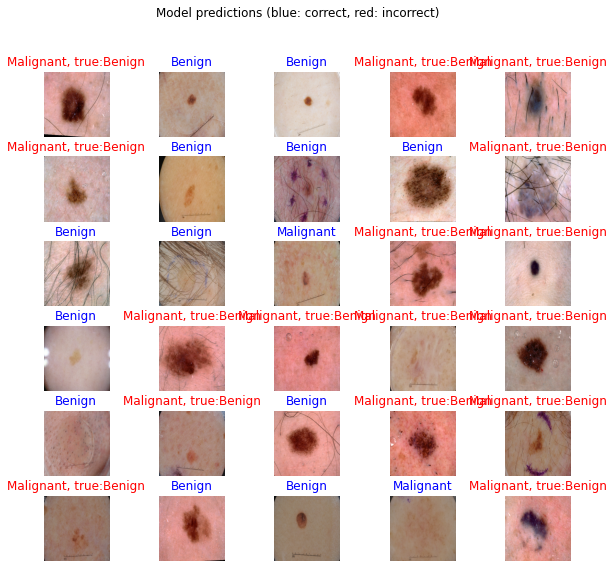

In [ ]:
def plot_images(X_test, y_pred, y_test):
  predicted_class_names = np.array([class_names[int(round(id))] for id in y_pred])
  # some nice plotting
  plt.figure(figsize=(10,9))
  for n in range(30, 60):
      plt.subplot(6,5,n-30+1)
      plt.subplots_adjust(hspace = 0.3)
      plt.imshow(X_test[n])
      # get the predicted label
      predicted_label = predicted_class_names[n]
      # get the actual true label
      true_label = class_names[int(round(y_test[n]))]
      if predicted_label == true_label:
          color = "blue"
          title = predicted_label.title()
      else:
          color = "red"
          title = f"{predicted_label.title()}, true:{true_label.title()}"
      plt.title(title, color=color)
      plt.axis('off')
  _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
  plt.show()

plot_images(X_test, y_pred, y_test)

In [ ]:
# a function given a function, it predicts the class of the image
def predict_image_class(img_path, model, threshold=0.5):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.expand_dims(img, 0) # Create a batch
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  predictions = model.predict(img)
  score = predictions.squeeze()
  if score >= threshold:
    print(f"This image is {100 * score:.2f}% malignant.")
  else:
    print(f"This image is {100 * (1 - score):.2f}% benign.")

  plt.imshow(img[0])
  plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 27ms/step


[[0.6803772]]
0.6803772
This image is 68.04% malignant.


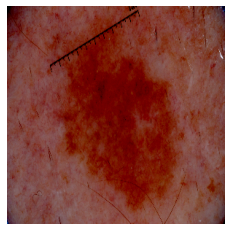

In [ ]:
predict_image_class("data/test/melanoma/ISIC_0013767.jpg", m)

1/1 [==============================] - 0s 50ms/step


[[0.21590327]]
0.21590327
This image is 78.41% benign.


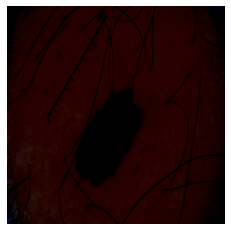

In [ ]:
predict_image_class("data/test/nevus/ISIC_0012092.jpg", m)

1/1 [==============================] - 0s 26ms/step


[[0.13682997]]
0.13682997
This image is 86.32% benign.


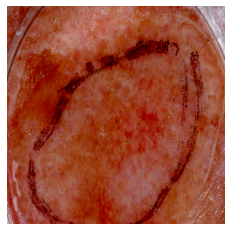

In [ ]:
predict_image_class("data/test/seborrheic_keratosis/ISIC_0012136.jpg", m)